In this notebook I m going to develop several sorts of auto-encoders and apply them to image reconstruction, faces and digits in particular, and sample new ones.
There presented below 3 types of auto-encoders: (basic) autoencoder, variational autoencoder (vae) and conditional vae. All these architectures are widely used in CV and i m going to cover only one application


# Basic Autoencoder

## Data preprocessing


In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image



%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [4]:
data, attrs = fetch_dataset()

images not found, donwloading...


--2023-05-02 09:47:00--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘tmp.tgz’

     0K .......... .......... .......... .......... ..........  0%  508K 3m29s
    50K .......... .......... .......... .......... ..........  0% 1017K 2m37s
   100K .......... .......... .......... .......... ..........  0% 55.6M 1m45s
   150K .......... .......... .......... .......... ..........  0% 40.3M 79s
   200K .......... .......... .......... .......... ..........  0% 1.03M 84s
   250K .......... .......... .......... .......... ..........  0% 40.9M 70s
   300K .......... .......... .......... .......... ..........  0% 47.9M 60s
   350K .......... .......... .......... .......... ..........  0% 79.2M 53s
   400K .......... ...

extracting...
lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg
lfw-deepfunneled/AJ_Lamas/AJ_Lamas_0001.jpg
lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg
lfw-deepfunneled/Aaron_Guiel/Aaron_Guiel_0001.jpg
lfw-deepfunneled/Aaron_Patterson/Aaron_Patterson_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0002.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0003.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0004.jpg
lfw-deepfunneled/Aaron_Pena/Aaron_Pena_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0002.jpg
lfw-deepfunneled/Aaron_Tippin/Aaron_Tippin_0001.jpg
lfw-deepfunneled/Abba_Eban/Abba_Eban_0001.jpg
lfw-deepfunneled/Abbas_Kiarostami/Abbas_Kiarostami_0001.jpg
lfw-deepfunneled/Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg
lfw-deepfunneled/Abdel_Madi_Shabneh/Abdel_Madi_Shabneh_0001.jpg
lfw-deepfunneled/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg
lfw-deepfunneled

--2023-05-02 09:47:05--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2023-05-02 09:47:05--  https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: ‘lfw_attributes.txt’

     0K .......... .......... .......... .......... ..........  0%  862K 17s
    50K .......... .......... .......... .......... ..........  0% 1.71M 12s
   100K .......... .......... .......... .......... ..........  1% 60.3M 8s
   150K .......... .......... .......... 

done


In [5]:
attrs.head()

Male     Asian     White     Black      Baby     Child     Youth  \
0  1.568346 -1.889043  1.737203 -0.929729 -1.471799  -0.19558 -0.835609   
1  0.169851 -0.982408  0.422709 -1.282184  -1.36006 -0.867002 -0.452293   
2  0.997749 -1.364195 -0.157377 -0.756447 -1.891825 -0.871526 -0.862893   
3  1.122719 -1.997799  1.916144 -2.514214 -2.580071 -1.404239  0.057551   
4  1.078214 -2.008098  1.676211 -2.278056 -2.651845 -1.348408  0.649089   

  Middle Aged    Senior Black Hair  ... Pale Skin 5 o' Clock Shadow  \
0   -0.351468 -1.012533  -0.719593  ...  0.361738          1.166118   
1   -0.197521 -0.956073  -0.802107  ... -0.832036          -0.39768   
2    0.031445 -1.341523  -0.090037  ...  1.549743          1.884745   
3    0.000196 -1.273512  -1.431462  ...  0.567822         -0.176089   
4    0.017656 -1.889111  -1.857213  ... -1.461474         -0.955283   

  Strong Nose-Mouth Lines Wearing Lipstick Flushed Face High Cheekbones  \
0               -1.164916         -1.13999    -2.371746       -1.299932   
1                 0.87416        -0.945431    -0.268649       -0.006244   
2               -0.999765        -1.359858    -1.912108       -1.095634   
3                1.108125        -1.600944    -3.264613        0.813418   
4                0.119113        -1.128176    -3.161048         0.08268   

  Brown Eyes Wearing Earrings Wearing Necktie Wearing Necklace  
0  -0.414682        -1.144902        0.694007        -0.826609  
1  -0.030406        -0.480128         0.66676        -0.496559  
2   0.915126        -0.572332        0.144262        -0.841231  
3   0.308631        -0.848693        0.475941        -0.447025  
4  -0.439614        -0.359859       -0.760774        -0.410152  

[5 rows x 73 columns]


Here I transform images according to requirements, split the on "train" and "test" and put them in dataloaders.

In [6]:
IMAGEX = 64
IMAGEY = 64

# data_resize = list(map(lambda x: skimage.transform.resize(x, (IMAGEY, IMAGEX)), data))
data_trans = list(map(lambda x: x.transpose(2, 0, 1), data))
data_torch = torch.FloatTensor(data_trans)
trainset, valset = train_test_split(data_torch, train_size = 0.9)

dataloader = {
    'train': DataLoader(trainset, batch_size=32, shuffle=True, drop_last=True),
    'valid': DataLoader(valset, batch_size=32),
}

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
  


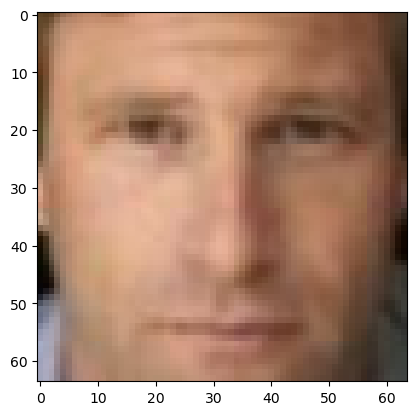

In [7]:
plt.imshow(data_torch[0].numpy().transpose(1,2,0))

## Autoencoder's architecture


<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">



Now I realise the architecture and training

In [8]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=2, padding=1),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(0.5),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            
            nn.Flatten(),
        )
        # 16 x 4 x 4
        self.decoder = nn.Sequential(
            nn.Unflatten(-1, (16, 4, 4)),
            
            nn.Conv2d(in_channels=16, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=(3, 3), padding=1),
            nn.Sigmoid(),
        )
        
    def forward(self, sample):
        latent = self.encoder(sample)
        reconstructed = self.decoder(latent)
        return reconstructed, latent
    
    def latent(self, sample):
        latent = self.encoder(sample)
        return latent
    
    def sample(self, z):
        generated = self.decoder(z)
        return generated

In [9]:
criterion = nn.MSELoss()
autoencoder = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters())

## Training

In [10]:
def train(model,optimizer,criterion,train_data,val_data, epochs = 20, device = torch.device('cpu')):
  val_batch = next(iter(val_data))

  train_losses = []
  val_losses = []
  progress = tqdm(range(epochs), desc='Epoch')
  for epoch in progress:
    for batch in train_data:
      batch = batch.to(device)
      # print(batch.shape)
      model.train()
      optimizer.zero_grad()
      
      reconstruction, latent_vector = model(batch)
      loss = criterion(batch, reconstruction)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      
    with torch.no_grad():
      model.eval()
      val_reconstruction, val_latent_vector = model(val_batch.to(device))
      loss = criterion(val_batch.to(device),val_reconstruction)
      # print(loss)
      val_losses.append(loss.cpu())
      
    print('\n',"train loss:", train_losses[-1].cpu().detach().numpy(),' valid loss:', val_losses[-1].cpu().detach().numpy())

  # return train_losses, val_losses

In [11]:
train(autoencoder,optimizer, criterion, dataloader['train'], dataloader['valid'], device = device)

Epoch:   5%|▌         | 1/20 [00:12<04:04, 12.89s/it]


 train loss: 0.008016627  valid loss: 0.0076656444


Epoch:  10%|█         | 2/20 [00:18<02:36,  8.72s/it]


 train loss: 0.0071671414  valid loss: 0.0066019106


Epoch:  15%|█▌        | 3/20 [00:24<02:06,  7.45s/it]


 train loss: 0.006103644  valid loss: 0.0064336304


Epoch:  20%|██        | 4/20 [00:30<01:49,  6.82s/it]


 train loss: 0.0058255326  valid loss: 0.005599156


Epoch:  25%|██▌       | 5/20 [00:36<01:37,  6.49s/it]


 train loss: 0.0040456313  valid loss: 0.0045505385


Epoch:  30%|███       | 6/20 [00:42<01:28,  6.29s/it]


 train loss: 0.004361891  valid loss: 0.0043278635


Epoch:  35%|███▌      | 7/20 [00:48<01:20,  6.19s/it]


 train loss: 0.004304568  valid loss: 0.004206617


Epoch:  40%|████      | 8/20 [00:54<01:13,  6.14s/it]


 train loss: 0.003699933  valid loss: 0.0036416398


Epoch:  45%|████▌     | 9/20 [01:00<01:07,  6.09s/it]


 train loss: 0.004950862  valid loss: 0.003435764


Epoch:  50%|█████     | 10/20 [01:06<01:00,  6.08s/it]


 train loss: 0.0058281096  valid loss: 0.0032697464


Epoch:  55%|█████▌    | 11/20 [01:12<00:54,  6.06s/it]


 train loss: 0.0031536627  valid loss: 0.0034799962


Epoch:  60%|██████    | 12/20 [01:18<00:48,  6.07s/it]


 train loss: 0.0062932037  valid loss: 0.0036384254


Epoch:  65%|██████▌   | 13/20 [01:24<00:42,  6.09s/it]


 train loss: 0.0035067673  valid loss: 0.003522216


Epoch:  70%|███████   | 14/20 [01:30<00:36,  6.11s/it]


 train loss: 0.0031439457  valid loss: 0.00320039


Epoch:  75%|███████▌  | 15/20 [01:36<00:30,  6.13s/it]


 train loss: 0.0035342078  valid loss: 0.0030602468


Epoch:  80%|████████  | 16/20 [01:43<00:24,  6.16s/it]


 train loss: 0.003226972  valid loss: 0.0030550538


Epoch:  85%|████████▌ | 17/20 [01:49<00:18,  6.19s/it]


 train loss: 0.0032235177  valid loss: 0.0029291734


Epoch:  90%|█████████ | 18/20 [01:55<00:12,  6.22s/it]


 train loss: 0.003112718  valid loss: 0.0029501251


Epoch:  95%|█████████▌| 19/20 [02:02<00:06,  6.26s/it]


 train loss: 0.0036768145  valid loss: 0.0028132498


Epoch: 100%|██████████| 20/20 [02:08<00:00,  6.42s/it]


 train loss: 0.0027947188  valid loss: 0.0029344975


## Face reconstruction

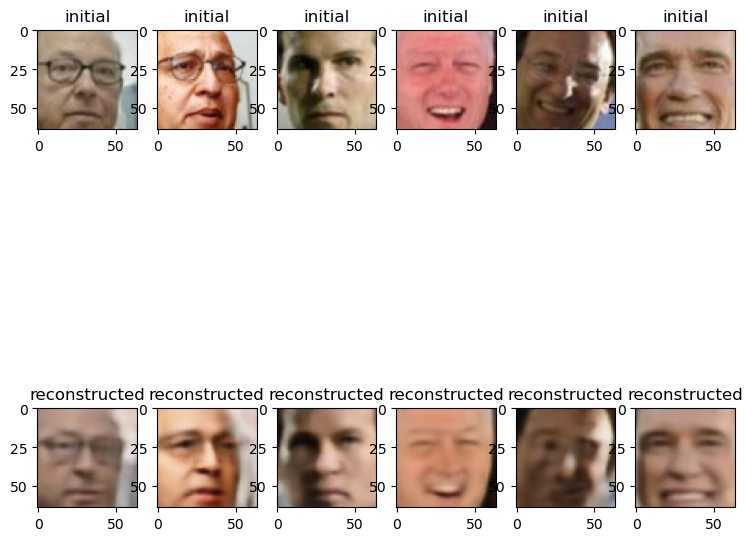

In [12]:
fig = plt.figure(figsize=(9, 9))
axes = fig.subplots(nrows=2, ncols=6)

batch = next(iter(dataloader['valid']))
reconstructions, latent_vecs = autoencoder(batch.to(device))

for i in range(len(valset[:6])):
  axes[0, i].imshow(valset[i].cpu().numpy().transpose(1,2,0))
  axes[0, i].set_title('initial')

  img_recon = reconstructions[i] 
  axes[1, i].imshow(img_recon.cpu().detach().numpy().transpose(1,2,0))
  axes[1, i].set_title('reconstructed')

Not bad, right? 

## Sampling

In this part, using normal distribution and mean and std of training dataset, i sample several images as example.

In [13]:
latents = torch.Tensor()
for inputs in tqdm(dataloader['train']):
    inputs = inputs.to(device)
    with torch.no_grad():
        latent = autoencoder.latent(inputs).cpu()
        latents = torch.cat((latents, latent))
latents.shape

100%|██████████| 369/369 [00:01<00:00, 219.85it/s]


torch.Size([11808, 256])

In [14]:
lat_mean = latents.mean(dim=0)
lat_std = latents.std(dim=0)
lat_mean.shape, lat_std.shape

(torch.Size([256]), torch.Size([256]))

In [15]:
z = torch.FloatTensor(np.random.randn(25, 256))
z = z * lat_std/2 + lat_mean
output = autoencoder.sample(z.to(device)).cpu().detach()

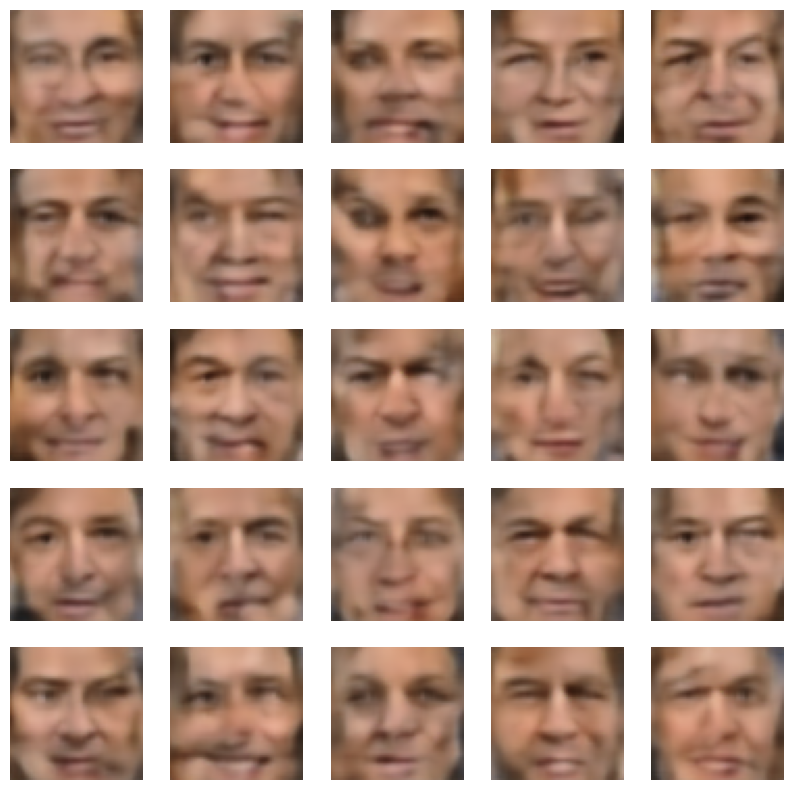

In [16]:
rows, cols = (5, 5)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
for ax, img in zip(axes.flatten(), output):
    ax.axis('off')
    ax.imshow(img.numpy().transpose(1, 2, 0))

## Make people smile

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

The pipeline is as following:
1. I take several images of smiling people and find the latent vectore for each image
2. Then I do the same procedure for nom-smiling people
3. Afterwards I derive "smile" by subtracting mean latent vector of non-smiling people from mean latent vector of smiling people
4. And ultimately I add "smile" vector to any picture of non-smiling person

In [17]:
smile = [171, 308, 1433, 1984, 2593, 2816, 3722, 3843, 4623, 4810, 5046, 5071, 5448, 5497, 5619, 6220, 6468, 6842]
non_smile = [170, 307, 1432, 1983, 2594, 2815, 3721, 3844, 4622, 4809, 5047, 5072, 5447, 5496, 5620, 6221, 6467, 6843]
input_smile = torch.FloatTensor(data_torch[smile])
input_non_smile = torch.FloatTensor(data_torch[non_smile])

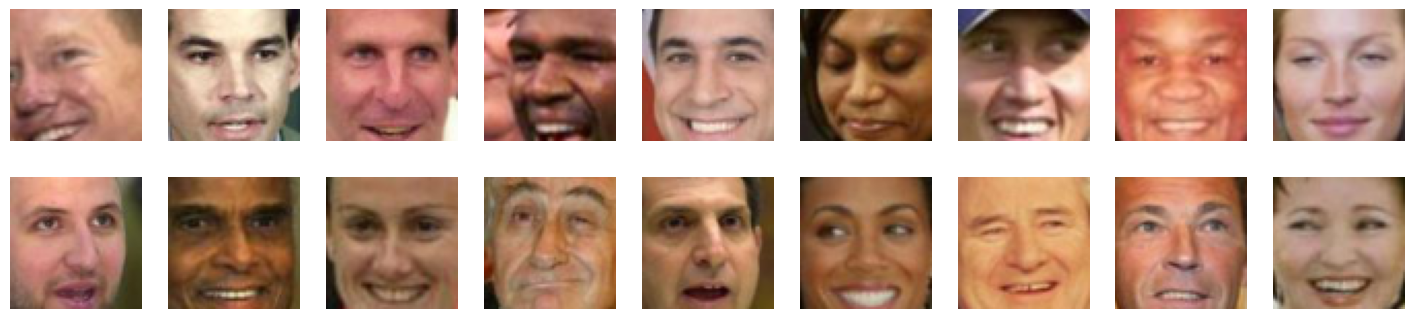

In [18]:
#smiling
rows, cols = (2,9)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
for ax, img in zip(axes.flatten(), input_smile):
    ax.axis('off')
    ax.imshow(img.numpy().transpose(1, 2, 0))

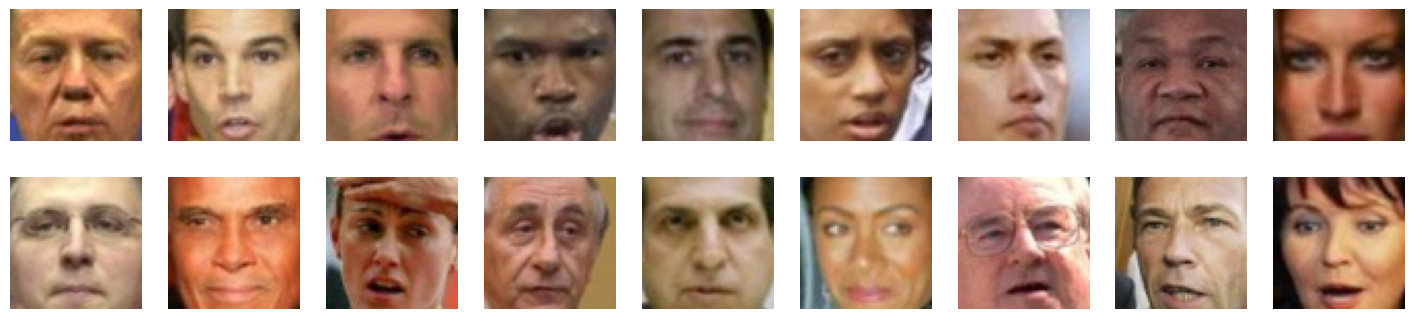

In [19]:
#non smiling
rows, cols = (2,9)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
for ax, img in zip(axes.flatten(), input_non_smile):
    ax.axis('off')
    ax.imshow(img.numpy().transpose(1, 2, 0))

In [20]:
input_smile = input_smile.to(device)
input_non_smile = input_non_smile.to(device)
autoencoder.eval()
with torch.no_grad():
    latent_smile = autoencoder.latent(input_smile).cpu()
    latent_non_smile = autoencoder.latent(input_non_smile).cpu()

In [21]:
smile = latent_smile.mean(dim = 0) - latent_non_smile.mean(dim = 0)

In [22]:
sad_faces = [0, 2, 12, 16, 21, 2112, 2120, 2116]
sad_faces = torch.Tensor(data_torch[sad_faces])
sad_faces = sad_faces.to(device)
autoencoder.eval()
with torch.no_grad():
    latent_sad = autoencoder.latent(sad_faces).cpu()
    latent_sad_to_smile = (latent_sad + smile).to(device)
    smile_faces = autoencoder.sample(latent_sad_to_smile)
faces = torch.cat((sad_faces.cpu(), smile_faces.cpu()))

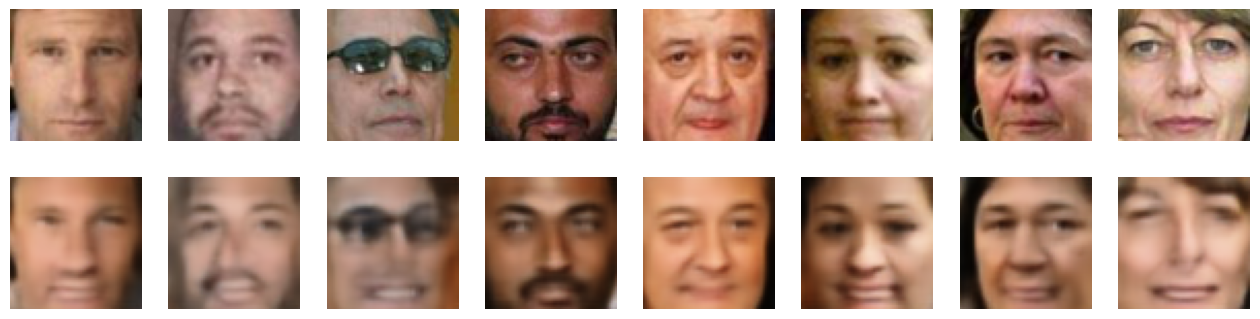

In [23]:
rows, cols = (2,8)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
for ax, img in zip(axes.flatten(), faces):
    ax.axis('off')
    ax.imshow(img.numpy().transpose(1, 2, 0))

# Now I move to VAE

As a dataset i use MNIST dataset including digits, which I m going to reconstruct and sample.

In [24]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_nums = list(map(lambda x: x[0].to(device),train_dataset))
test_nums = list(map(lambda x: x[0].to(device),test_dataset))

train_loader = torch.utils.data.DataLoader(dataset=torch.stack(train_nums),
                                           batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=torch.stack(test_nums),
                                          batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## Variational Autoencoder's architecture

In [25]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        #encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=2, padding=1),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(0.5),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(in_channels=128, out_channels=64*2, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            
            nn.Flatten(),
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.Unflatten(-1, (16, 4, 4)),
            
            nn.Conv2d(in_channels=16, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(3, 3), padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        latent = self.encoder(x).view(-1, 2, 256)

        mu = latent[:,0,:] # the first feature values as mean
        logsigma = latent[:,1,:] # the other feature values as variance
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            return mu
    
    def decode(self, z):
        reconstruction = self.decoder(z)
        
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x) # the other feature values as variance
        z = self.gaussian_sampler(mu, logsigma)

        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

Now I set the loss function for VAE:

The loss function consists of 2 separate losses: KL и log-likelihood.

Adding the together it looks as following:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Formula of KL-divergence:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

For log-likelihood I use binary cross-entropy.

In [26]:
class KLDivergenceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu, logsigma):
        return -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())


class VAELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.kl_divergence = KLDivergenceLoss()
        self.log_likelihood = nn.BCELoss(reduction='sum')

    def forward(self,x, mu, logsigma, reconstruction ):
        return self.kl_divergence(mu, logsigma) + self.log_likelihood(reconstruction, x)

The training

In [27]:
criterion = VAELoss()

vae = VAE().to(device)

optimizer = torch.optim.Adam(vae.parameters())

In [28]:
device = 'cuda'
def train(model,optimizer,criterion,train_data,val_data, epochs = 70, device = torch.device('cpu')):
  val_batch = next(iter(val_data)).to(device)

  train_losses = []
  val_losses = []
  progress = tqdm(range(epochs), desc='Epoch')
  for epoch in progress:
    for batch in train_data:
      batch = batch.to(device)
      model.train()
      optimizer.zero_grad()
      
      mu, logsigma, reconstruction = model(batch.cuda())
      loss = criterion(batch.cuda(), mu, logsigma, reconstruction)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      
    with torch.no_grad():
      model.eval()
      val_mu, val_logsigma, val_reconstruction = model(val_batch.cuda())
      loss = criterion(val_batch.cuda(), val_mu, val_logsigma, val_reconstruction)
      val_losses.append(loss.cpu())
      
    print('\n',"train loss:", train_losses[-1].cpu().detach().numpy(),' valid loss:', val_losses[-1].cpu().detach().numpy())

  # return train_losses, val_losses

In [29]:
train(vae, optimizer, criterion, train_loader, test_loader)

Epoch:   1%|▏         | 1/70 [00:20<23:03, 20.05s/it]


 train loss: 5949.5586  valid loss: 5301.1177


Epoch:   3%|▎         | 2/70 [00:40<22:40, 20.00s/it]


 train loss: 5396.6514  valid loss: 4684.687


Epoch:   4%|▍         | 3/70 [00:59<21:59, 19.69s/it]


 train loss: 5123.9  valid loss: 4392.6035


Epoch:   6%|▌         | 4/70 [01:19<21:48, 19.83s/it]


 train loss: 4922.9546  valid loss: 4414.9434


Epoch:   7%|▋         | 5/70 [01:39<21:33, 19.90s/it]


 train loss: 4823.678  valid loss: 4391.919


Epoch:   9%|▊         | 6/70 [01:58<21:05, 19.77s/it]


 train loss: 4849.6724  valid loss: 4324.2393


Epoch:  10%|█         | 7/70 [02:18<20:46, 19.79s/it]


 train loss: 4646.8296  valid loss: 4251.255


Epoch:  11%|█▏        | 8/70 [02:38<20:17, 19.64s/it]


 train loss: 4933.416  valid loss: 4338.564


Epoch:  13%|█▎        | 9/70 [02:57<20:02, 19.71s/it]


 train loss: 4833.4507  valid loss: 4363.201


Epoch:  14%|█▍        | 10/70 [03:17<19:42, 19.71s/it]


 train loss: 4840.875  valid loss: 4409.377


Epoch:  16%|█▌        | 11/70 [03:37<19:18, 19.63s/it]


 train loss: 4701.658  valid loss: 4273.2534


Epoch:  17%|█▋        | 12/70 [03:56<18:58, 19.63s/it]


 train loss: 4690.9375  valid loss: 4507.469


Epoch:  19%|█▊        | 13/70 [04:16<18:41, 19.68s/it]


 train loss: 4693.8745  valid loss: 4267.9004


Epoch:  20%|██        | 14/70 [04:35<18:16, 19.57s/it]


 train loss: 4599.5664  valid loss: 4309.0444


Epoch:  21%|██▏       | 15/70 [04:55<17:56, 19.58s/it]


 train loss: 4665.2334  valid loss: 4227.628


Epoch:  23%|██▎       | 16/70 [05:14<17:33, 19.52s/it]


 train loss: 4717.465  valid loss: 4397.9614


Epoch:  24%|██▍       | 17/70 [05:34<17:18, 19.59s/it]


 train loss: 4774.4175  valid loss: 4281.009


Epoch:  26%|██▌       | 18/70 [05:54<17:03, 19.68s/it]


 train loss: 4915.017  valid loss: 4337.295


Epoch:  27%|██▋       | 19/70 [06:13<16:39, 19.59s/it]


 train loss: 4849.051  valid loss: 4358.4053


Epoch:  29%|██▊       | 20/70 [06:33<16:22, 19.66s/it]


 train loss: 4764.715  valid loss: 4489.5596


Epoch:  30%|███       | 21/70 [06:53<16:02, 19.65s/it]


 train loss: 4768.4585  valid loss: 4409.6206


Epoch:  31%|███▏      | 22/70 [07:12<15:35, 19.50s/it]


 train loss: 4639.9565  valid loss: 4434.4688


Epoch:  33%|███▎      | 23/70 [07:32<15:18, 19.55s/it]


 train loss: 4719.0854  valid loss: 4331.8545


Epoch:  34%|███▍      | 24/70 [07:51<14:56, 19.48s/it]


 train loss: 4808.2725  valid loss: 4421.282


Epoch:  36%|███▌      | 25/70 [08:11<14:39, 19.54s/it]


 train loss: 4663.188  valid loss: 4470.1396


Epoch:  37%|███▋      | 26/70 [08:30<14:19, 19.53s/it]


 train loss: 4628.5327  valid loss: 4384.674


Epoch:  39%|███▊      | 27/70 [08:49<13:55, 19.44s/it]


 train loss: 4737.424  valid loss: 4340.12


Epoch:  40%|████      | 28/70 [09:09<13:38, 19.49s/it]


 train loss: 4641.3096  valid loss: 4442.2075


Epoch:  41%|████▏     | 29/70 [09:28<13:18, 19.49s/it]


 train loss: 4625.3247  valid loss: 4402.26


Epoch:  43%|████▎     | 30/70 [09:48<12:59, 19.50s/it]


 train loss: 4668.8555  valid loss: 4571.5283


Epoch:  44%|████▍     | 31/70 [10:08<12:40, 19.51s/it]


 train loss: 4651.628  valid loss: 4457.2427


Epoch:  46%|████▌     | 32/70 [10:27<12:17, 19.42s/it]


 train loss: 4706.054  valid loss: 4608.2485


Epoch:  47%|████▋     | 33/70 [10:46<12:02, 19.52s/it]


 train loss: 4463.7993  valid loss: 4512.791


Epoch:  49%|████▊     | 34/70 [11:06<11:47, 19.66s/it]


 train loss: 4694.0894  valid loss: 4365.4224


Epoch:  50%|█████     | 35/70 [11:26<11:23, 19.54s/it]


 train loss: 4819.1484  valid loss: 4778.8096


Epoch:  51%|█████▏    | 36/70 [11:46<11:07, 19.65s/it]


 train loss: 4568.7793  valid loss: 4570.9927


Epoch:  53%|█████▎    | 37/70 [12:05<10:46, 19.60s/it]


 train loss: 4653.754  valid loss: 4596.864


Epoch:  54%|█████▍    | 38/70 [12:25<10:32, 19.78s/it]


 train loss: 4561.8276  valid loss: 4754.2275


Epoch:  56%|█████▌    | 39/70 [12:45<10:14, 19.81s/it]


 train loss: 4477.4775  valid loss: 4437.4473


Epoch:  57%|█████▋    | 40/70 [13:05<09:50, 19.69s/it]


 train loss: 4735.2617  valid loss: 4562.0967


Epoch:  59%|█████▊    | 41/70 [13:24<09:32, 19.75s/it]


 train loss: 4631.8223  valid loss: 4701.3867


Epoch:  60%|██████    | 42/70 [13:44<09:14, 19.80s/it]


 train loss: 4756.5083  valid loss: 4733.243


Epoch:  61%|██████▏   | 43/70 [14:04<08:50, 19.66s/it]


 train loss: 4660.449  valid loss: 4657.0947


Epoch:  63%|██████▎   | 44/70 [14:24<08:32, 19.71s/it]


 train loss: 4730.3193  valid loss: 4338.541


Epoch:  64%|██████▍   | 45/70 [14:43<08:09, 19.60s/it]


 train loss: 4610.9556  valid loss: 4622.7427


Epoch:  66%|██████▌   | 46/70 [15:03<07:52, 19.68s/it]


 train loss: 4627.933  valid loss: 4831.793


Epoch:  67%|██████▋   | 47/70 [15:23<07:35, 19.79s/it]


 train loss: 4581.7563  valid loss: 4620.0234


Epoch:  69%|██████▊   | 48/70 [15:42<07:12, 19.66s/it]


 train loss: 4670.6313  valid loss: 4754.9546


Epoch:  70%|███████   | 49/70 [16:02<06:55, 19.79s/it]


 train loss: 4551.3213  valid loss: 4612.324


Epoch:  71%|███████▏  | 50/70 [16:22<06:36, 19.83s/it]


 train loss: 4880.901  valid loss: 4707.164


Epoch:  73%|███████▎  | 51/70 [16:42<06:14, 19.73s/it]


 train loss: 4659.914  valid loss: 4669.7334


Epoch:  74%|███████▍  | 52/70 [17:01<05:55, 19.76s/it]


 train loss: 4792.335  valid loss: 4713.363


Epoch:  76%|███████▌  | 53/70 [17:21<05:34, 19.67s/it]


 train loss: 4496.383  valid loss: 4562.5244


Epoch:  77%|███████▋  | 54/70 [17:41<05:15, 19.71s/it]


 train loss: 4645.9263  valid loss: 4612.4653


Epoch:  79%|███████▊  | 55/70 [18:00<04:54, 19.66s/it]


 train loss: 4609.248  valid loss: 4844.291


Epoch:  80%|████████  | 56/70 [18:20<04:33, 19.52s/it]


 train loss: 4610.315  valid loss: 4660.1406


Epoch:  81%|████████▏ | 57/70 [18:39<04:14, 19.57s/it]


 train loss: 4626.724  valid loss: 5240.2197


Epoch:  83%|████████▎ | 58/70 [18:59<03:55, 19.60s/it]


 train loss: 4693.037  valid loss: 4711.878


Epoch:  84%|████████▍ | 59/70 [19:18<03:34, 19.50s/it]


 train loss: 4589.006  valid loss: 4858.2764


Epoch:  86%|████████▌ | 60/70 [19:38<03:15, 19.53s/it]


 train loss: 4632.4297  valid loss: 4871.446


Epoch:  87%|████████▋ | 61/70 [19:57<02:55, 19.45s/it]


 train loss: 4504.1406  valid loss: 5088.398


Epoch:  89%|████████▊ | 62/70 [20:17<02:36, 19.52s/it]


 train loss: 4612.0825  valid loss: 4727.4033


Epoch:  90%|█████████ | 63/70 [20:36<02:17, 19.58s/it]


 train loss: 4637.0186  valid loss: 4928.606


Epoch:  91%|█████████▏| 64/70 [20:56<01:56, 19.44s/it]


 train loss: 4678.175  valid loss: 5146.2324


Epoch:  93%|█████████▎| 65/70 [21:15<01:37, 19.55s/it]


 train loss: 4596.5884  valid loss: 4866.332


Epoch:  94%|█████████▍| 66/70 [21:35<01:18, 19.61s/it]


 train loss: 4463.889  valid loss: 4714.167


Epoch:  96%|█████████▌| 67/70 [21:55<00:58, 19.58s/it]


 train loss: 4662.7065  valid loss: 4697.7754


Epoch:  97%|█████████▋| 68/70 [22:14<00:39, 19.60s/it]


 train loss: 4561.59  valid loss: 5016.474


Epoch:  99%|█████████▊| 69/70 [22:34<00:19, 19.53s/it]


 train loss: 4569.9307  valid loss: 4877.122


Epoch: 100%|██████████| 70/70 [22:53<00:00, 19.63s/it]


 train loss: 4828.429  valid loss: 4633.439


The digits reconstruction:

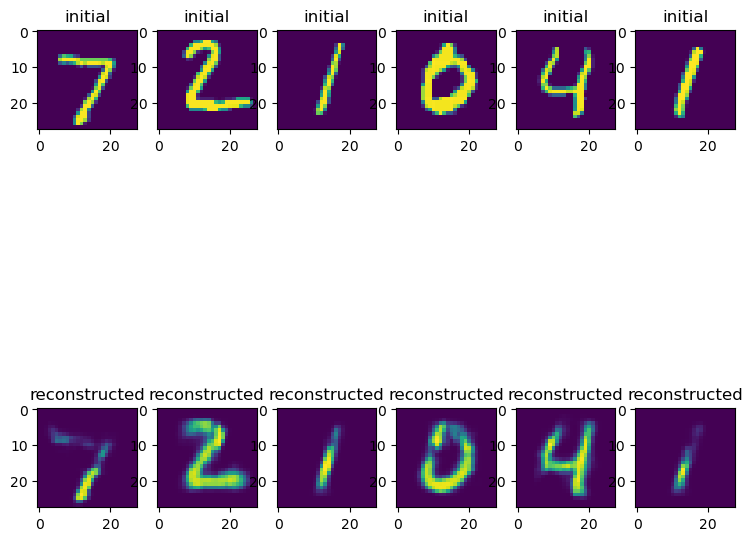

In [30]:
fig = plt.figure(figsize=(9, 9))
axes = fig.subplots(nrows=2, ncols=6)

batch = next(iter(test_loader))
_,_,reconstructions= vae(batch.to(device))

for i in range(len(test_nums[:6])):
  axes[0, i].imshow(test_nums[i].cpu().numpy().transpose(1,2,0))
  axes[0, i].set_title('initial')

  img_recon = reconstructions[i] 
  axes[1, i].imshow(img_recon.cpu().detach().numpy().transpose(1,2,0))
  axes[1, i].set_title('reconstructed')

Now I m going to do the same procedure as I did with basic autoencoder, but I use digits' images instead of faces.

In [31]:
latents = torch.Tensor()
for inputs in tqdm(train_loader):
    inputs = inputs.to(device)
    with torch.no_grad():
        mu, logsigma = vae.encode(inputs)
        z = vae.gaussian_sampler(mu, logsigma)
        latents = torch.cat((latents.cpu(), z.cpu()))

lat_mean = latents.mean(dim=0)
lat_std = latents.std(dim=0)


100%|██████████| 1875/1875 [00:13<00:00, 142.41it/s]


In [32]:
z = torch.FloatTensor([np.random.normal(0, 1, 256) for i in range(10)])
z = z * lat_std + lat_mean

vae.eval()
with torch.no_grad():
    sample = vae.decode(z.to(device))
sample = sample.cpu().detach()

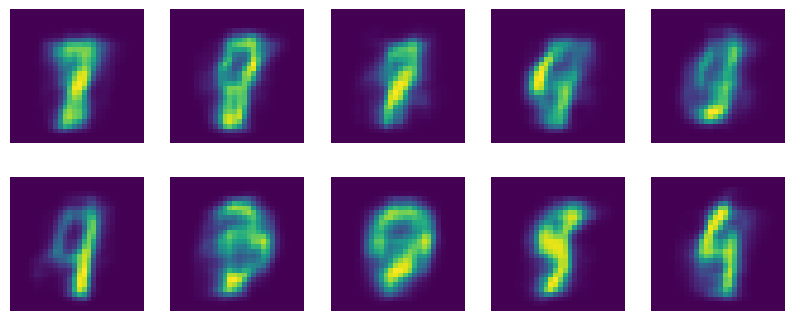

In [33]:
rows, cols = (2, 5)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
for ax, img in zip(axes.flatten(), sample):
    ax.axis('off')
    ax.imshow(img.numpy().transpose(1, 2, 0))

## Latent Representation

Let's see how latent vectors of face images look in space.
Your task is to represent the latent vectors of images as points in two-dimensional space.

This will allow us to estimate how densely the latent vectors of digit images are distributed in space.

Plus, let's do this thing: paint the dots that correspond to the pictures of each digit in their own separate color

So, the pipeline:
1. Get latent representations of test dataset images
2. Using `TSNE` (there is in `sklearn`), compress these representations to dimension 2 (so that they can be visualized as points in space)
3. Visualize the resulting two-dimensional representations using 'matplotlib.scatter', paint the dots corresponding to the pictures of different numbers with different colors.

In [34]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.patheffects as PathEffects

In [35]:
x = latents[::5].numpy()
colors = np.array([color for _, color in train_dataset])[::5]

ts = TSNE(random_state=42, verbose=2).fit_transform(x)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12000 samples in 0.005s...
[t-SNE] Computed neighbors for 12000 samples in 6.352s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 1.681766
[t-SNE] Computed cond

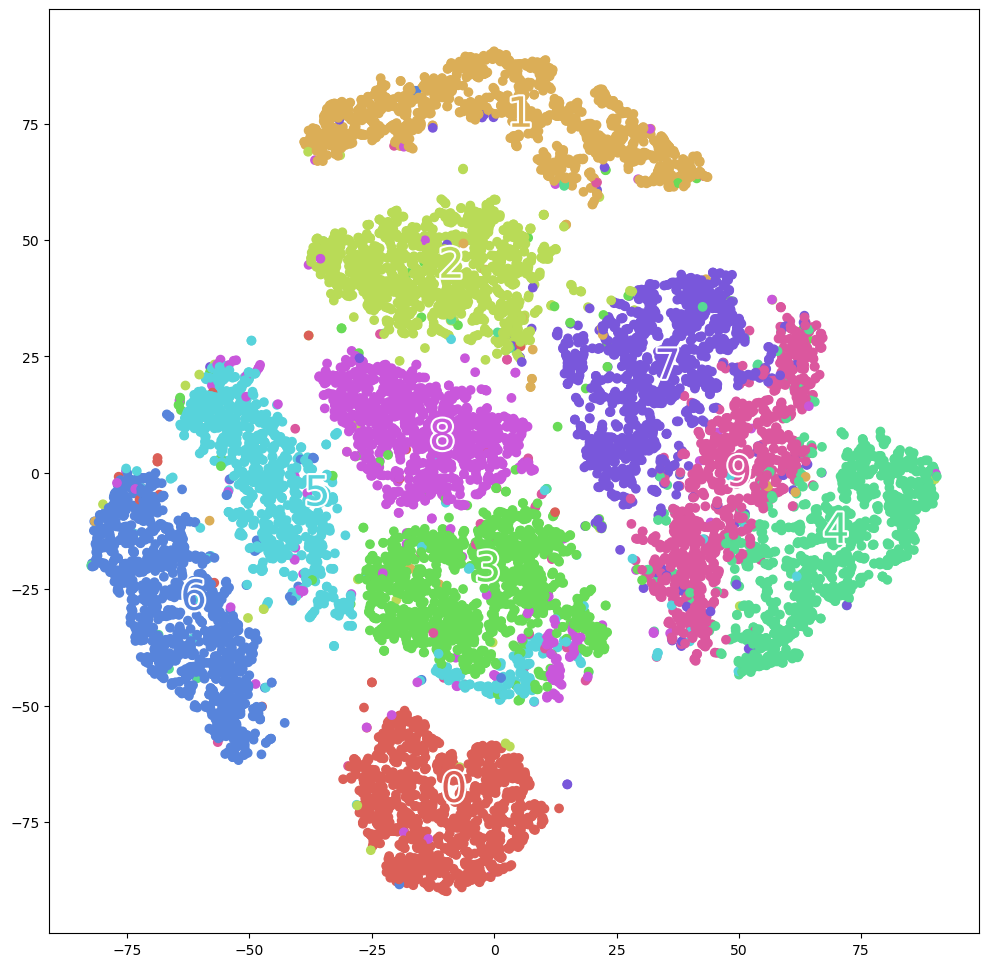

In [36]:
palette = np.array(sns.color_palette("hls", 10))
fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(ts[:,0], ts[:,1], c=palette[colors])
plt.axis('tight')

for i in range(10):
    labelx, labely = np.mean(ts[colors == i, :], axis=0)
    lbl = ax.text(labelx, labely, str(i), c=palette[i], fontsize=30)
    lbl.set_path_effects([
        PathEffects.Stroke(linewidth=3, foreground="w"),
        PathEffects.Normal()
    ])
plt.show()

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## Conditional VAE


### Architecture

The picture below shows the architecture of a simple Conditional VAE.

In fact, the only difference from the usual one is that we, together with the picture in the first layer of the encoder and decoder, transmit more information about the class of the picture.

That is, a concatenation of the image and class information (for example, a vector of nine zeros and one unit) is fed into the first (input) layer of the encoder. Concatenation of the latent vector and class information is fed into the first layer of the decoder.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



Thus, when generating a new random image, we will have to pass the concatenated latent vector and the class of the image to the decoder.

In [37]:
class CVAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        #encoder
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(
                in_features=(1*28*28),
                out_features=256,
            ),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.25),
            nn.Linear(in_features=128, out_features=(32 * 2)),
        )
        self.decoder = nn.Sequential(
            nn.Linear(
                in_features=(32 + 10),
                out_features=128,
            ),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.25),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),
            nn.Linear(
                in_features=256,
                out_features=(1 * 28 * 28),
            ),
            nn.Sigmoid(),
        )

    def encode(self, x):
        flat = self.flatten(x)
        latent = self.encoder(flat).view(-1,2,32)
        
        mu = latent[:,0,:] # the first feature values as mean
        logsigma = latent[:,1,:] # the other feature values as variance
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            return mu
    
    def decode(self, z):
        reconstruction = self.decoder(z).view(-1, 1, 28, 28)
        
        return reconstruction

    def forward(self, x, labels):
        mu, logsigma = self.encode(x)
        
        z = self.gaussian_sampler(mu, logsigma)

        z_new = torch.cat((z, labels),1)
        reconstruction = self.decode(z_new)

        return mu, logsigma, reconstruction

In [38]:
from sklearn.preprocessing import OneHotEncoder

In [39]:
y_train = np.array([digit for _, digit in train_dataset])
y_test = np.array([digit for _, digit in test_dataset])

In [40]:
ohencoder = OneHotEncoder()
train_encoded = ohencoder.fit_transform(y_train.reshape(-1,1))
test_encoded = ohencoder.transform(y_test.reshape(-1,1))

In [41]:
train_labels = torch.FloatTensor(train_encoded.toarray()).to(device)
test_labels = torch.FloatTensor(test_encoded.toarray()).to(device)

In [42]:
train_ds = list(map(lambda x,y: (x,y),train_nums,train_labels))
test_ds = list(map(lambda x,y: (x,y),test_nums,test_labels))


train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_ds,
                                          batch_size=batch_size, shuffle=False)

In [43]:
criterion = VAELoss()

cvae = CVAE().to(device)

optimizer = torch.optim.Adam(cvae.parameters())

In [44]:
def train(model,optimizer,criterion,train_data,val_data, epochs = 70, device = torch.device('cpu')):
  val_data, val_labels = next(iter(val_data))

  train_losses = []
  val_losses = []
  progress = tqdm(range(epochs), desc='Epoch')
  for epoch in progress:
    for batch in train_data:
      data = batch[0].to(device)
      labels = batch[1].to(device)
      model.train()
      optimizer.zero_grad()
      
      mu, logsigma, reconstruction = model(data.cuda(), labels.cuda())
      loss = criterion(data.cuda(), mu, logsigma, reconstruction)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      
    with torch.no_grad():
      model.eval()
      val_mu, val_logsigma, val_reconstruction = model(val_data.cuda(),val_labels.cuda())
      loss = criterion(val_data.cuda(), val_mu, val_logsigma, val_reconstruction)
      # print(loss)
      val_losses.append(loss.cpu())
      
    print('\n',"train loss:", train_losses[-1].cpu().detach().numpy(),' valid loss:', val_losses[-1].cpu().detach().numpy())

  # return train_losses, val_losses

In [45]:
train(cvae, optimizer, criterion, train_loader, test_loader)

Epoch:   1%|▏         | 1/70 [00:14<16:28, 14.32s/it]


 train loss: 5523.8  valid loss: 3987.5742


Epoch:   3%|▎         | 2/70 [00:25<14:25, 12.73s/it]


 train loss: 5129.4336  valid loss: 3750.033


Epoch:   4%|▍         | 3/70 [00:37<13:34, 12.16s/it]


 train loss: 5277.2617  valid loss: 3658.0742


Epoch:   6%|▌         | 4/70 [00:48<12:55, 11.75s/it]


 train loss: 5052.8003  valid loss: 3589.2742


Epoch:   7%|▋         | 5/70 [01:00<12:42, 11.73s/it]


 train loss: 4972.8755  valid loss: 3533.1875


Epoch:   9%|▊         | 6/70 [01:11<12:18, 11.54s/it]


 train loss: 4968.0264  valid loss: 3525.154


Epoch:  10%|█         | 7/70 [01:22<11:58, 11.40s/it]


 train loss: 4995.7363  valid loss: 3497.2146


Epoch:  11%|█▏        | 8/70 [01:34<11:51, 11.48s/it]


 train loss: 4869.642  valid loss: 3451.798


Epoch:  13%|█▎        | 9/70 [01:45<11:37, 11.43s/it]


 train loss: 4957.7627  valid loss: 3447.4036


Epoch:  14%|█▍        | 10/70 [01:57<11:29, 11.49s/it]


 train loss: 5032.6636  valid loss: 3455.856


Epoch:  16%|█▌        | 11/70 [02:08<11:20, 11.54s/it]


 train loss: 5002.796  valid loss: 3430.2153


Epoch:  17%|█▋        | 12/70 [02:19<11:03, 11.43s/it]


 train loss: 5042.7505  valid loss: 3409.4434


Epoch:  19%|█▊        | 13/70 [02:31<10:53, 11.46s/it]


 train loss: 5019.911  valid loss: 3423.8376


Epoch:  20%|██        | 14/70 [02:42<10:36, 11.37s/it]


 train loss: 4957.9033  valid loss: 3404.0173


Epoch:  21%|██▏       | 15/70 [02:53<10:21, 11.31s/it]


 train loss: 5026.404  valid loss: 3411.3882


Epoch:  23%|██▎       | 16/70 [03:05<10:16, 11.41s/it]


 train loss: 5025.529  valid loss: 3382.5696


Epoch:  24%|██▍       | 17/70 [03:16<10:01, 11.35s/it]


 train loss: 4819.879  valid loss: 3382.2627


Epoch:  26%|██▌       | 18/70 [03:27<09:46, 11.28s/it]


 train loss: 4895.4917  valid loss: 3371.2563


Epoch:  27%|██▋       | 19/70 [03:39<09:42, 11.42s/it]


 train loss: 4936.517  valid loss: 3385.3008


Epoch:  29%|██▊       | 20/70 [03:50<09:26, 11.34s/it]


 train loss: 4900.0933  valid loss: 3369.6526


Epoch:  30%|███       | 21/70 [04:01<09:13, 11.29s/it]


 train loss: 4936.2295  valid loss: 3369.0566


Epoch:  31%|███▏      | 22/70 [04:13<09:05, 11.37s/it]


 train loss: 4773.5283  valid loss: 3373.3003


Epoch:  33%|███▎      | 23/70 [04:24<08:51, 11.31s/it]


 train loss: 4798.814  valid loss: 3357.0781


Epoch:  34%|███▍      | 24/70 [04:36<08:48, 11.49s/it]


 train loss: 4941.232  valid loss: 3354.7185


Epoch:  36%|███▌      | 25/70 [04:47<08:30, 11.36s/it]


 train loss: 4856.22  valid loss: 3341.618


Epoch:  37%|███▋      | 26/70 [04:58<08:16, 11.29s/it]


 train loss: 5016.9595  valid loss: 3343.4453


Epoch:  39%|███▊      | 27/70 [05:10<08:08, 11.37s/it]


 train loss: 4900.2573  valid loss: 3323.697


Epoch:  40%|████      | 28/70 [05:21<07:54, 11.29s/it]


 train loss: 5003.669  valid loss: 3351.9902


Epoch:  41%|████▏     | 29/70 [05:32<07:40, 11.23s/it]


 train loss: 4938.1826  valid loss: 3337.539


Epoch:  43%|████▎     | 30/70 [05:43<07:32, 11.32s/it]


 train loss: 4753.2183  valid loss: 3332.9036


Epoch:  44%|████▍     | 31/70 [05:55<07:18, 11.25s/it]


 train loss: 4963.6924  valid loss: 3337.0862


Epoch:  46%|████▌     | 32/70 [06:06<07:09, 11.29s/it]


 train loss: 4842.25  valid loss: 3322.7205


Epoch:  47%|████▋     | 33/70 [06:18<07:01, 11.38s/it]


 train loss: 4942.947  valid loss: 3321.0627


Epoch:  49%|████▊     | 34/70 [06:29<06:45, 11.28s/it]


 train loss: 4735.6816  valid loss: 3330.733


Epoch:  50%|█████     | 35/70 [06:40<06:32, 11.21s/it]


 train loss: 4882.412  valid loss: 3334.2168


Epoch:  51%|█████▏    | 36/70 [06:51<06:23, 11.27s/it]


 train loss: 4860.2607  valid loss: 3320.4038


Epoch:  53%|█████▎    | 37/70 [07:02<06:11, 11.25s/it]


 train loss: 4735.8916  valid loss: 3329.7827


Epoch:  54%|█████▍    | 38/70 [07:14<06:03, 11.35s/it]


 train loss: 4976.853  valid loss: 3324.5479


Epoch:  56%|█████▌    | 39/70 [07:25<05:49, 11.26s/it]


 train loss: 4911.5947  valid loss: 3315.7563


Epoch:  57%|█████▋    | 40/70 [07:36<05:35, 11.20s/it]


 train loss: 4895.3853  valid loss: 3324.655


Epoch:  59%|█████▊    | 41/70 [07:47<05:27, 11.28s/it]


 train loss: 4745.6465  valid loss: 3328.1694


Epoch:  60%|██████    | 42/70 [07:59<05:15, 11.27s/it]


 train loss: 4871.479  valid loss: 3338.0598


Epoch:  61%|██████▏   | 43/70 [08:10<05:03, 11.23s/it]


 train loss: 4860.7183  valid loss: 3320.704


Epoch:  63%|██████▎   | 44/70 [08:21<04:54, 11.32s/it]


 train loss: 4843.562  valid loss: 3309.886


Epoch:  64%|██████▍   | 45/70 [08:32<04:41, 11.25s/it]


 train loss: 4768.975  valid loss: 3296.3687


Epoch:  66%|██████▌   | 46/70 [08:43<04:28, 11.21s/it]


 train loss: 4959.566  valid loss: 3328.2546


Epoch:  67%|██████▋   | 47/70 [08:55<04:20, 11.32s/it]


 train loss: 4737.003  valid loss: 3315.2905


Epoch:  69%|██████▊   | 48/70 [09:06<04:08, 11.28s/it]


 train loss: 4843.5757  valid loss: 3318.1704


Epoch:  70%|███████   | 49/70 [09:18<03:57, 11.31s/it]


 train loss: 4823.9453  valid loss: 3297.0527


Epoch:  71%|███████▏  | 50/70 [09:29<03:48, 11.41s/it]


 train loss: 4917.738  valid loss: 3312.8213


Epoch:  73%|███████▎  | 51/70 [09:40<03:35, 11.35s/it]


 train loss: 4864.5557  valid loss: 3313.138


Epoch:  74%|███████▍  | 52/70 [09:52<03:25, 11.43s/it]


 train loss: 4817.723  valid loss: 3292.8174


Epoch:  76%|███████▌  | 53/70 [10:03<03:13, 11.36s/it]


 train loss: 4720.8813  valid loss: 3323.6335


Epoch:  77%|███████▋  | 54/70 [10:14<03:00, 11.30s/it]


 train loss: 4913.0376  valid loss: 3308.5308


Epoch:  79%|███████▊  | 55/70 [10:26<02:51, 11.41s/it]


 train loss: 4787.327  valid loss: 3341.2463


Epoch:  80%|████████  | 56/70 [10:37<02:38, 11.32s/it]


 train loss: 4858.9966  valid loss: 3305.6003


Epoch:  81%|████████▏ | 57/70 [10:48<02:26, 11.27s/it]


 train loss: 5046.7207  valid loss: 3286.7505


Epoch:  83%|████████▎ | 58/70 [11:00<02:16, 11.42s/it]


 train loss: 4742.8994  valid loss: 3308.4944


Epoch:  84%|████████▍ | 59/70 [11:11<02:05, 11.37s/it]


 train loss: 4709.2017  valid loss: 3315.5122


Epoch:  86%|████████▌ | 60/70 [11:23<01:53, 11.31s/it]


 train loss: 5039.1206  valid loss: 3317.3398


Epoch:  87%|████████▋ | 61/70 [11:34<01:42, 11.41s/it]


 train loss: 4724.2954  valid loss: 3299.3794


Epoch:  89%|████████▊ | 62/70 [11:45<01:30, 11.33s/it]


 train loss: 4861.9873  valid loss: 3317.1897


Epoch:  90%|█████████ | 63/70 [11:57<01:19, 11.30s/it]


 train loss: 4707.5654  valid loss: 3288.2827


Epoch:  91%|█████████▏| 64/70 [12:08<01:08, 11.39s/it]


 train loss: 4878.8057  valid loss: 3305.9927


Epoch:  93%|█████████▎| 65/70 [12:19<00:56, 11.33s/it]


 train loss: 4786.045  valid loss: 3301.2417


Epoch:  94%|█████████▍| 66/70 [12:31<00:45, 11.40s/it]


 train loss: 4802.358  valid loss: 3306.8215


Epoch:  96%|█████████▌| 67/70 [12:42<00:34, 11.35s/it]


 train loss: 4740.6123  valid loss: 3297.3042


Epoch:  97%|█████████▋| 68/70 [12:53<00:22, 11.28s/it]


 train loss: 4848.953  valid loss: 3331.4822


Epoch:  99%|█████████▊| 69/70 [13:05<00:11, 11.38s/it]


 train loss: 4806.9443  valid loss: 3279.8862


Epoch: 100%|██████████| 70/70 [13:16<00:00, 11.38s/it]


 train loss: 4910.1304  valid loss: 3299.996


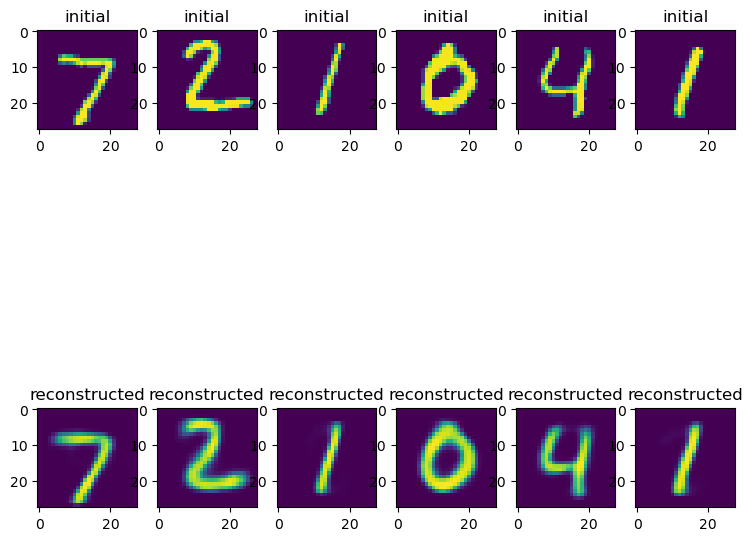

In [46]:
fig = plt.figure(figsize=(9, 9))
axes = fig.subplots(nrows=2, ncols=6)

data, labels = next(iter(test_loader))
_,_,reconstructions= cvae(data.to(device), labels.to(device))

for i in range(len(test_nums[:6])):
  axes[0, i].imshow(test_nums[i].cpu().numpy().transpose(1,2,0))
  axes[0, i].set_title('initial')

  img_recon = reconstructions[i] 
  axes[1, i].imshow(img_recon.cpu().detach().numpy().transpose(1,2,0))
  axes[1, i].set_title('reconstructed')

### Sampling


Here we will sample from CVAE. This is more fun than sampling from a simple AE/VAE: here you can take the same latent vector and ask CVAE to restore images of different classes from it!
For MNIST, you can ask CVAE to restore from a single latent vector, for example, images of the numbers 5 and 7.

In [56]:
sample5_data = []
for ind, i in enumerate(y_train):
    if i == 5:
        sample5_data.append(train_ds[ind])

sample5_loader = torch.utils.data.DataLoader(dataset = sample5_data, batch_size = 32, shuffle = False)

sample7_data = []
for ind, i in enumerate(y_train):
    if i == 7:
        sample7_data.append(train_ds[ind])

sample7_loader = torch.utils.data.DataLoader(dataset = sample7_data, batch_size = 32, shuffle = False)

In [61]:
latents5 = torch.Tensor()
for batch in sample5_loader:
    data = batch[0].to(device)
    labels = batch[1].to(device)
    cvae.eval()
    with torch.no_grad():
        mu, logsigma = cvae.encode(data)
        z = cvae.gaussian_sampler(mu, logsigma)
        z_new = torch.cat((z, labels), 1)
        latents5 = torch.cat((latents5.cpu(), z_new.cpu()))

lat_mean5 = latents5.mean(dim=0)
lat_std5 = latents5.std(dim=0)

latents7 = torch.Tensor()
for batch in sample7_loader:
    data = batch[0].to(device)
    labels = batch[1].to(device)
    cvae.eval()
    with torch.no_grad():
        mu, logsigma = cvae.encode(data)
        z = cvae.gaussian_sampler(mu, logsigma)
        z_new = torch.cat((z, labels), 1)
        latents7 = torch.cat((latents7.cpu(), z_new.cpu()))

lat_mean7 = latents7.mean(dim=0)
lat_std7 = latents7.std(dim=0)

In [63]:
z = torch.FloatTensor([np.random.normal(0, 1, 42) for i in range(10)])
z5 = z * lat_std5 + lat_mean5
z7 = z * lat_std7 + lat_mean7

cvae.eval()
with torch.no_grad():
    sample5 = cvae.decode(z5.to(device))
    sample7 = cvae.decode(z7.to(device))
sample5 = sample5.cpu().detach()
sample7 = sample7.cpu().detach()

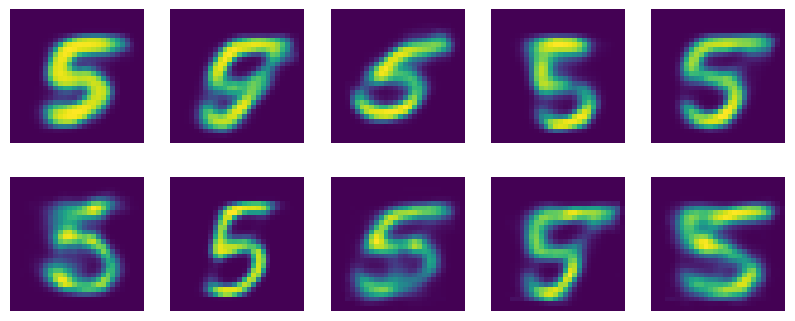

In [64]:
rows, cols = (2, 5)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
for ax, img in zip(axes.flatten(), sample5):
    ax.axis('off')
    ax.imshow(img.numpy().transpose(1, 2, 0))

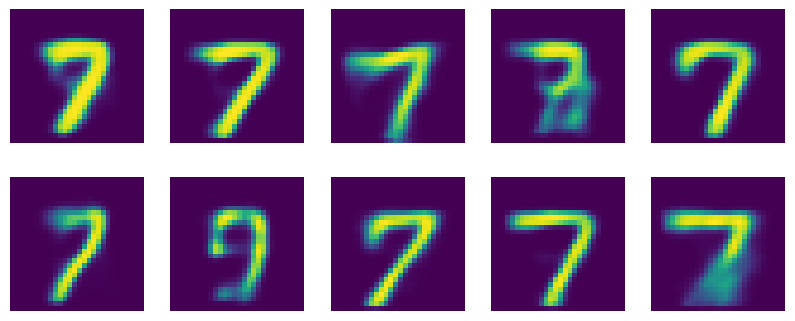

In [65]:
rows, cols = (2, 5)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
for ax, img in zip(axes.flatten(), sample7):
    ax.axis('off')
    ax.imshow(img.numpy().transpose(1, 2, 0))

### Latent Representations

Here i repeat procedure of latent representation for CVAE

In [66]:
latents = torch.Tensor()
for inputs in tqdm(train_loader):
    inputs = inputs[0].to(device)
    with torch.no_grad():
        mu, logsigma = cvae.encode(inputs)
        z = cvae.gaussian_sampler(mu, logsigma)
        latents = torch.cat((latents.cpu(), z.cpu()))

100%|██████████| 1875/1875 [00:02<00:00, 901.03it/s]


In [67]:
x = latents[::5].numpy()
colors = np.array([color for _, color in train_dataset])[::5]

ts = TSNE(random_state=42, verbose=2).fit_transform(x)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12000 samples in 0.001s...
[t-SNE] Computed neighbors for 12000 samples in 4.674s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 0.894901
[t-SNE] Computed cond

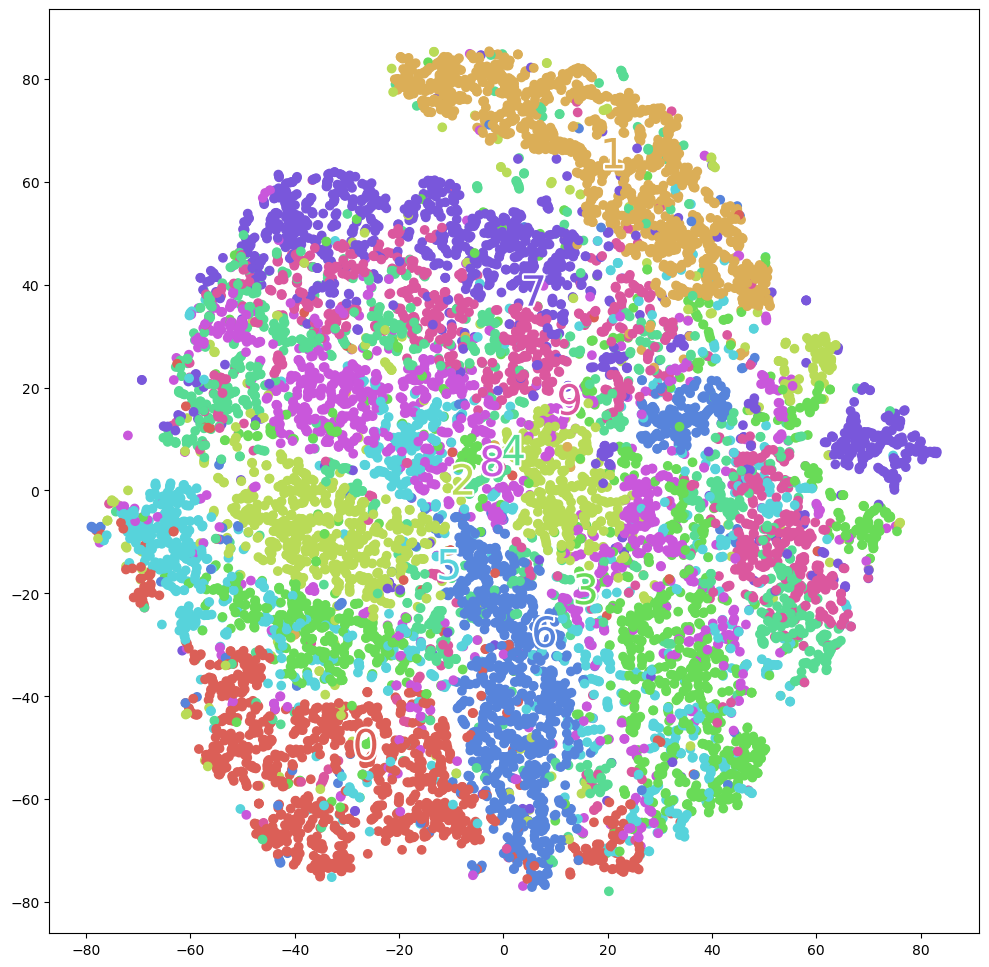

In [68]:
palette = np.array(sns.color_palette("hls", 10))
fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(ts[:,0], ts[:,1], c=palette[colors])
plt.axis('tight')

for i in range(10):
    labelx, labely = np.mean(ts[colors == i, :], axis=0)
    lbl = ax.text(labelx, labely, str(i), c=palette[i], fontsize=30)
    lbl.set_path_effects([
        PathEffects.Stroke(linewidth=3, foreground="w"),
        PathEffects.Normal()
    ])
plt.show()